In [14]:
from editor import Editor
from Box2D.b2 import pi

# edit your model by running this cell
# to add a body part hit b and it will spawn under your mouse
# to move body parts drag them with the mouse
# to connect body parts, hit p to pin two bodies at the mouse location
# to change a body part's size, click and hold, then use the arrow keys to modify width/height
# hit 's' to save while editing to model.json

editor = Editor()
editor.load('creatures/pole.json')
editor.run()

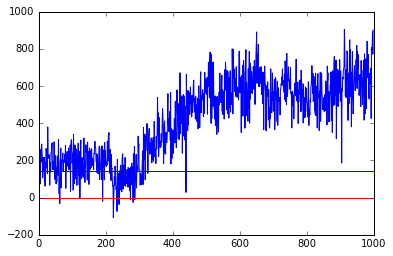

episode: 1500 variance: 1 grads: 42


In [60]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import clear_output
import pygame
from pygame.locals import (KEYDOWN, K_RIGHT, K_LEFT, K_UP, K_DOWN, K_r, K_s)
from Box2D.b2 import pi
from engine import Engine
from time import sleep

# train your model to (hopefully) walk by running this cell

# hit s to speed up training, and s again to watch the best set of weights
# use the up and down arrow keys to introduce more or less randomness in weight changes

# this cell is an experiment with policy improvement
# the agent's joint torques (continuous, action) are randomly sampled from means output by a neural network
# the gradient wrt the weights of that network, for that state, are saved each time step
# if the average reward at the end of an episode is positive, we want the agent to act more like it did
# if the reward was negative we want it to act less like it did that episode

FILE = 'creatures/bisected.json'

# Physics engine and window
LOWER_LIM = -.1 * np.pi
UPPER_LIM = .1 * np.pi
LIMIT = True
ANGLE_RANGE = UPPER_LIM - LOWER_LIM if LIMIT else np.pi*2.0

engine = Engine(caption='Train', width=1280, height=720, gravity=(0, -50), joint_limit=LIMIT, \
               upper_angle=UPPER_LIM, lower_angle=LOWER_LIM, linear_damping=0.0, angular_damping=0.0)

# Add floor
engine.add_static_body(p=(engine.width/2, engine.height-10), size=(engine.width * 10, 10))

# Load creature
engine.load(FILE)

# count joints and body parts
body_count = len(engine.world.bodies) - 1 # subtract ground body
joint_count = len(engine.world.joints)

if body_count == 0 or joint_count == 0:
    engine.close()
    raise RuntimeError("Your model doesn't have any physics bodies or joints")

def features(time_step=0):
    f = []
    
    for b in engine.world.bodies:
        if b.userData and isinstance(b.userData, dict):
            a = b.angle % ANGLE_RANGE
            a /= ANGLE_RANGE
            a = a * 2.0 - 1.0
            f += [a]
            f += [b.angularVelocity]
            f += [b.linearVelocity[0]]
            f += [b.linearVelocity[1]]
            #f += [np.sin(a)]
            #f += [np.cos(a)]
            f += [engine.to_screen(b.position)[0]/engine.height]
    
    #f += [np.sin(time_step / 2.0)] # Creature's heartbeat? :-)
    #f += [1] # bias
    return np.array([f])
    
def body_position():
    avg = np.zeros([2])
    for b in engine.world.bodies:
        if b.userData:
            avg += [b.position[0], b.position[1]]
    avg /= body_count
    return engine.to_screen(avg)

def set_position(position, zero_vel=True):
    current = engine.to_pybox2d(body_position())
    position = engine.to_pybox2d(position)
    shift = (position[0] - current[0], position[1] - current[1])
    for b in engine.world.bodies:
        if b.userData:
            if zero_vel:
                b.linearVelocity = (0, 0)
                b.angularVelocity = 0
            b.position = (b.position[0] + shift[0], b.position[1] + shift[1])


TIMESTEPS = 40 # timesteps per episode
exploration_length = 100

total_r = 0.0
episode = 0

learning_rate = .02
variance = 1 # increase or decrease deviation from means output by nn
scale = 0.05

hdim = 16

act = lambda x: np.tanh(x)
act_p = lambda x: 1.0 - np.tanh(x)**2
#act = lambda x: x * (x > 0)
#act_p = lambda x: (x > 0).astype(np.float)

W1 = np.random.random_sample([features().shape[1], hdim]) * scale - scale/2 # initial set of weights
W2 = np.random.random_sample([hdim, joint_count]) * scale - scale/2 # initial set of weights

bestW1 = W1.copy()
bestW2 = W2.copy()

rs = []
grads = []
max_r = float('-inf')

g1 = np.zeros_like(W1)
g2 = np.zeros_like(W2)

speedup = False
running = True

while running:
    rs += [total_r]
            
    if episode % 100 == 0:
        clear_output(wait=True)
        
        if len(rs) > 1000:
            rs = rs[-1000:]
        fig = plt.plot(rs, 'b')
        plt.plot([0, len(rs)], [0, 0], 'r')
        plt.plot([0, len(rs)], [max_r, max_r], 'b')
        plt.show()
        
        #plt.figure(figsize=(10, 10))
        #plt.imshow(W2, interpolation='nearest')
        #plt.colorbar()
        #plt.show()

        print('episode: {} variance: {} grads: {}'.format(episode, np.round(variance, 2), len(grads)))
    
    if episode < exploration_length:
        if total_r > max_r:
            max_r = total_r
            bestW1 = W1.copy()
            bestW2 = W2.copy()
        W1 = np.random.randn(features().shape[1], hdim) * scale
        W2 = np.random.randn(hdim, joint_count) * scale
    elif episode == exploration_length:
        W1 = bestW1.copy()
        W2 = bestW2.copy()
        speedup = False
    elif episode > exploration_length:
        # go through each gradient and apply
        segment = rs[-4:]
        r = (total_r - np.average(segment))/np.std(segment)
        #r = np.tanh(r)
        
        g1[:] = 0
        g2[:] = 0
        
        for grad in grads:
            g1 += grad['g1']
            g2 += grad['g2']
            
        W1 += learning_rate * g1 / float(TIMESTEPS) * r
        W2 += learning_rate * g2 / float(TIMESTEPS) * r
        
        #g1 *= 0.3
        #g2 *= 0.3
    
    
    # new episode
    engine.clear_all_but_ground()
    engine.load(FILE)
    
    set_position((engine.width/2 - 400, engine.height/2))
    
    for j in engine.world.joints:
        j.motorSpeed = np.random.randn()
    
    engine.step_physics(50)
    for b in engine.world.bodies:
        b.linearVelocity = (0, 0)
        b.angularVelocity = 0
    
    start_p = body_position()
    t = 0
    total_r = 0.0
    grads = []
    
    episode += 1
    
    reset = False
    
    while not reset:
        engine.clear_screen()
        
        # keyboard input
        for event in engine.events():
            if engine.quit_event(event):
                running = False
                reset = True
            if event.type == KEYDOWN:
                k = pygame.key.get_pressed()
                if k[K_UP]:
                    variance += 0.1
                elif k[K_DOWN]:
                    variance -= 0.1
                elif k[K_s]:
                    speedup = not speedup
                    if not speedup:
                        reset = True
                variance = max(variance, 0.1)
        
        x = features(t)
        z1 = x.dot(W1)
        h1 = act(z1)
        z2 = h1.dot(W2)
        
        #torques = z2 + np.random.randn(z2.shape[0], z2.shape[1]) * variance
        torques = np.array([np.random.normal(loc=u, scale=np.sqrt(variance)) for u in z2[0]])
        
        start_p = body_position()
        
        for i, j in enumerate(engine.world.joints):
            j.motorSpeed = torques[i]
        
        
        for i in range(10):
            engine.step_physics(1)
            if not speedup:
                engine.clear_screen()
                
                #p = body_position()
                #p = (int(p[0]), int(p[1]))
                #engine.draw_circle(p, 10, (0, 255, 0))
                
                engine.render()
                engine.clock_tick()
        
        end_p = body_position()
        
        # reward
        #reward = np.average([engine.to_screen(b.position)[0]/engine.width - .5 for b in engine.world.bodies])
        reward = (end_p[0] - start_p[0])
        #reward = 1 if end_p[0] > start_p[0] else 0
        #reward = 1.0 - np.average([engine.to_screen(b.position)[1]/engine.height for b in engine.world.bodies])

        total_r += reward
        
        if end_p[0] > engine.width-100:
            set_position((engine.width/2-400, end_p[1]))
        
        # grad
        if episode > exploration_length:
            delta = (torques - z2) / variance
            g2 = np.multiply(h1.T, delta)
            dh1 = W2.dot(delta.T).T
            dz1 = np.multiply(dh1, act_p(z1))
            g1 = np.multiply(x.T, dz1)
            
            grad = {'g1': g1, 'g2': g2}
            grads += [grad]
        
        if t > TIMESTEPS:
            reset = True
            engine.render()
        
        if not speedup:
            engine.render()
            engine.clock_tick()

        # prepare for next rounds
        t += 1

engine.close()

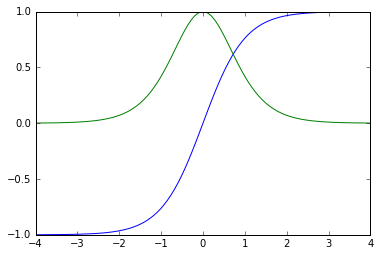

In [28]:
X = np.linspace(-4, 4, 100)
plt.plot(X, np.tanh(X))
plt.plot(X, 1.0 - np.tanh(X)**2)

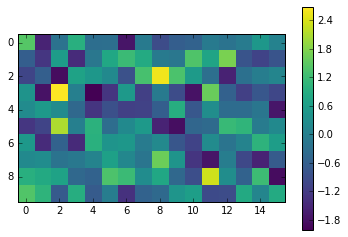

In [75]:
plt.imshow(W1, interpolation='nearest', cmap=plt.cm.viridis)
plt.colorbar()

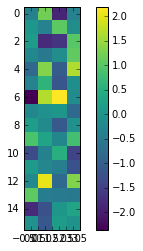

In [74]:
plt.imshow(W2, interpolation='nearest', cmap=plt.cm.viridis)
plt.colorbar()